# **Sommario**
**Step 1: Raccolta dei dati**
* CSV dataset ✓ (kaggle job dataset 1.2M+ ennuple https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024).
* Importare csv in python con Pandas (selezionare solo le colonne utili) ✓

**Step 2: Preprocessing dei dati (per tutto il dataset)**
* Pulizia dei dati ✓
* Tokenizzazione ✓
* Rimozione delle stop words ✓
* Stemming o Lemmatization ✓

**Step 3: Feature Extraction**
* Bag of Words (BoW) oppure TF-IDF ✓
* Word Embeddings: Utilizzare tecniche come Word2Vec o GloVe per ottenere rappresentazioni dense delle parole. ✓

**Step 4: Riduzione di dimensionalità**
* Principal Component Analisys (PCA) ✓

**Step 5: Creazione del Modello**
* Dividere il dataset in set di addestramento e di test. ✓
* Modelli Classici: Random Forest, SVM, Logistic Regression. -> **classificatore multi-label per ogni skill** ✓
* Reti neurali semplici ✓
* Deep Learning: Reti neurali ricorrenti (RNN), LSTM, Transformer.

**Step 6: Addestramento del Modello**
* Addestrare il modello sui dati di addestramento. ✓
* Valutare le prestazioni sui dati di test. -> **cross-validation** ✓

**Step 7: Valutazione del Modello**\
Utilizzare metriche di valutazione appropriate per giudicare l'efficacia del modello, come precision, recall, F1-score. ✓

# **Metodi utilizzati nel notebook**

Metodo per il pre-processing del testo

In [ ]:
import regex as re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download dei dataset necessari per nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Definizione delle stop words e inizializzazione del lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocessing
def preprocess(text):
    # Pulizia del testo
    text = re.sub(r"[^a-zA-Z\s]", '', text) # Rimozione di stringhe composte solo da caratteri speciali e/o numeri
    text = re.sub(r'\(.*?\)', '', str(text)).lower().replace(',', '').replace('  ', ' ') # Rimozione del contenuto tra parentesi
    # Tokenizzazione
    tokens = nltk.word_tokenize(text)
    # Stopping
    tokens = [w for w in tokens if w not in stop_words]
    # Lemmatizzazione
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return ' '.join(tokens)

def preprocess_skills(text):
    # Pulizia del testo
    text = str(text).replace('"','').replace("'",'').strip("[]") # Rimozione di virgolette e parentesi
    text = text.lower()
    text = re.sub(r',\s*[^\w\s][^,]*|,\s*\d[^,]*', '', text) # Rimozione di sottostringhe delimitate da virgole che iniziano con un numero o carattere speciale
    # Tokenizzazione
    tokens = text.split(',')
    tokens = [token.replace('  ',' ') for token in tokens] # Rimozione dei doppi spazi dopo lo split
    return tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Metodo per l'individuazione delle etichette rappresentative di un cluster

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# Definizione funzione per etichette rappresentative
def find_representative_skill(cluster_index, centroids, embedded_labels):
    # Seleziona solo le skill del cluster corrente
    cluster_skills = embedded_labels[embedded_labels['cluster'] == cluster_index]
    # Calcola le distanze tra ogni skill e il centroide del cluster
    distances = euclidean_distances(cluster_skills.iloc[:, :-2], centroids[cluster_index].reshape(1, -1))
    # Argmin restituisce l'indice della skill più vicina al centroide
    closest_skill_index = np.argmin(distances)
    # Restituisce il nome della skill rappresentativa
    return cluster_skills.iloc[closest_skill_index]['skill']

Metodo per sostituire le skill nella lista con quelle rappresentative del cluster a cui appartengono

In [ ]:
# Funzione per sostituire le skill nella lista con quelle rappresentative
def replace_with_representative_skills(skills):
    return list(set([skill_to_representative_map.get(skill, skill) for skill in skills]))

Metodo per il calcolo del vettore medio di embedding

In [ ]:
from gensim.models import Word2Vec
import numpy as np

# Definisco la funzione di calcolo dell'embedding per una descrizione, cioè la media tra i vettori di embedding di ogni termine
def get_average_word2vec(tokens_list, model, vector_size):
    if len(tokens_list) < 1:
        return np.zeros(vector_size)
    vector = np.mean([model[token] for token in tokens_list if token in model] or [np.zeros(vector_size)], axis=0)
    return vector

# **Step 1: Raccolta dei dati**

In [1]:
# Importazione librerie
import pandas as pd
import tensorflow as tf
import joblib

percorso_locale = 'D:/Users/Davide/Documents/Scuola/Uni/Magistrale/Primo Anno/ML/' # Percorso locale (cartella in cui è contenuto il dataset e in cui sarà salvato il modello)

In [23]:
# Impostazione delle opzioni Pandas
pd.set_option('display.max_columns', None)  # Mostra tutte le colonne
pd.set_option('display.max_rows', None)     # Mostra tutte le righe
pd.set_option('display.max_colwidth', None)  # Mostra l'intero contenuto delle celle

In [103]:
# Reset delle opzioni
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')

In [2]:
# Verifica disponibilità GPU
print('Available GPUs: ', len(tf.config.list_physical_devices('GPU')))

# Abilitazione dell'allocazione dinamica della memoria su GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
            print("Memory growth enabled succesfully for GPU: ", device)
    except RuntimeError as e:
        print(e)

Available GPUs:  1
Memory growth enabled succesfully for GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


```
# Importazione dei dataset di offerte e di skills utilizzando Pandas
descriptions_df = pd.read_csv(percorso_locale+'job_summary.csv')
skills_df = pd.read_csv(percorso_locale+'job_skills.csv')

# Unione dei csv sulla base della colonna 'job_link'
data = descriptions_df.merge(skills_df, on='job_link')

# Pulizia del datafame
import numpy as np
data.replace('', np.nan, inplace=True) # Sostituisci eventuali stringhe vuote con valori nulli
data.dropna(how='any') # Elimina una riga che ha anche solo un valore nullo

data.head()

# Salvataggio del dataset
data.to_csv(percorso_locale+'job_descriptions_and_skills.csv')
```

In [25]:
# Importazione del dataset utilizzando Pandas
data = pd.read_csv(percorso_locale+'job_descriptions_and_skills.csv', usecols=['job_skills', 'job_summary']) # Con il parametro nrows si limita il numero di righe

# Cambio nome delle colonne interessate in un dataframe Pandas
data.rename(columns={'job_skills':'skills', 'job_summary':'description'}, inplace = True)

# Visualizza le prime righe del DataFrame
data.head()

description  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

# **Step 2.1: Preprocessing dei dati - Elaborazione del testo**

Applicazione del metodo di preprocessing

In [26]:
# Applicazione della funzione di preprocessing creando una nuova colonna nel dataFrame per le descrizioni
data['description'] = data['description'].apply(preprocess)
print(data['description'])

# Applicazione della funzione di preprocessing creando una nuova colonna nel dataFrame per le skills
data['skills'] = data['skills'].apply(preprocess_skills)
print(data['skills'])

Criticità:
* Lo stemmer commette diversi errori -> si utilizza la Lemmatizzazione (approccio a dizionario) al suo posto;
* Il processo non è in grado di unire parole composte in token unici (es. *'social network'* viene erroneamente tokenizzato come *'social', 'network'*).

In [6]:
# Salvataggio del dataset preprocessato
data.to_pickle(percorso_locale+'data.pkl')

# **Step 2.2: Preprocessing dei dati - Gestione delle etichette**

**Importazione e analisi delle etichette**

In [4]:
# Importazione del dataset già preprocessato
data = pd.read_pickle(percorso_locale+'data.pkl')

In [ ]:
# Controllo della composizione dell'insieme delle etichette
all_skills = [skill for sublist in data['skills'] for skill in sublist]
skills_df = pd.DataFrame(all_skills, columns=['skill'])
label_counts = skills_df['skill'].value_counts()

all_present_labels = label_counts[label_counts == len(data)]
too_common_labels = label_counts[label_counts > 0.95 * len(data)]
too_rare_labels = label_counts[label_counts < 0.01 * len(data)]

print(f"Numero di skills presenti in tutte le descrizioni: {len(list(all_present_labels.index))}")
print(f"Numero di skills troppo comuni (>95%): {len(list(too_common_labels.index))}")
print(f"Numero di skills troppo rare (<1%): {len(list(too_rare_labels.index))}")

# Percentuale di appartenenza alle descrizioni per ogni etichetta
label_percentages = (label_counts / len(data)) * 100
print(f"\nSkill|% di apparizione: \n{label_percentages}")

Numero di skills presenti in tutte le descrizioni: 0
Numero di skills troppo comuni (>95%): 0
Numero di skills troppo rare (<1%): 13251

      Skill          |   % di apparizione: 
 communication          37.85
 customer service       36.70
 leadership             23.00
 teamwork               19.25
 problem solving        16.40
                        ...  
 eye care                0.05
 ophthalmology           0.05
 computer scheduling     0.05
 rescheduling            0.05
 acute care hospital     0.05
Name: skill, Length: 13504, dtype: float64


Il numero di etichette è estremamente elevato e sparso, sarà necessario diminuirne il numero e la sparsità aggregando etichette simili effettuando un clustering basato sulle co-occorrenze delle skills stesse oppure sui loro valori di embedding.

In [ ]:
# Calcola la frequenza delle skill
skill_freq = data['skills'].apply(lambda x: [skill for skill in x if label_counts[skill] == 1])

# Calcola la percentuale di skill uniche per ogni riga
unique_skill_pct = skill_freq.apply(lambda x: len(x) / len(data['skills'].iloc[0]))

# Scarta le righe con più della metà delle skill uniche
data = data[unique_skill_pct < 0.5]

**Embedding delle etichette**

In [ ]:
import gensim

skills_list = data['skills'].tolist() # é una lista di liste, ogni lista interna è l'elenco delle skill di una riga
skills_set = set([skill for list in skills_list for skill in list]) # Isolo le skill presenti nelle liste # è un set contenente tutte le skill senza ripetizioni
single_skills = [skill.split() for skill in skills_set] # è una lista di liste, ogni lista interna è l'elenco delle parole di una skill

# Definizione del modello w2v per le etichette
# w2v_model = Word2Vec(single_skills, vector_size=100, window=5, min_count=1, workers=4)
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(percorso_locale+'w2v_model.bin', binary=True)

In [ ]:
embedded_labels = pd.DataFrame([get_average_word2vec(terms, w2v_model, w2v_model.vector_size) for terms in (single_skills)], columns=[f'ED{i+1}' for i in range(w2v_model.vector_size)])
embedded_labels['skill'] = list(skills_set) # Ad ogni riga di embedding è accodato il nome della skill di riferimento

embedded_labels.head()

,ED1,ED2,ED3,ED4,ED5,ED6,ED7,ED8,ED9,ED10,...,ED92,ED93,ED94,ED95,ED96,ED97,ED98,ED99,ED100,skill
0,0.003696,-0.000952,-0.004907,-0.007669,0.008788,0.001642,-0.009057,-0.005930,-0.003402,-0.000275,...,0.003606,0.006632,-0.002928,0.004520,-0.004965,0.001786,0.007945,-0.007783,-0.004227,biztalk
1,0.006431,0.001478,-0.006569,-0.002114,0.007215,0.006332,-0.003306,0.009451,-0.001863,-0.008266,...,-0.007385,-0.007331,0.007545,-0.000839,0.007351,0.006390,0.004763,-0.001269,0.007473,state licensure in clinical discipline
2,-0.000143,-0.008157,0.000396,-0.002391,-0.001995,0.004564,0.007134,-0.006711,0.008802,-0.005829,...,-0.005646,0.009947,0.001379,-0.008308,0.002665,-0.001288,0.003267,0.007158,0.005535,big data technologies
3,-0.007582,0.001664,0.008484,-0.004223,0.003595,0.000201,-0.001193,0.000241,0.009362,0.001788,...,-0.004972,0.004763,0.008208,0.009842,0.003531,-0.000957,-0.002652,-0.002326,-0.003677,purchase orders (pos)
4,-0.006523,0.003874,0.006429,0.002173,-0.007427,0.008523,0.009187,-0.007892,-0.002670,-0.005014,...,0.003319,-0.008748,-0.009292,0.001403,-0.007691,-0.000059,-0.001716,-0.008527,-0.007883,erp


In [ ]:
embedded_labels.to_pickle(percorso_locale+'embedded_labels.pkl')

In [ ]:
embedded_labels = pd.read_pickle(percorso_locale+'embedded_labels.pkl')

**Clustering delle etichette embeddate**

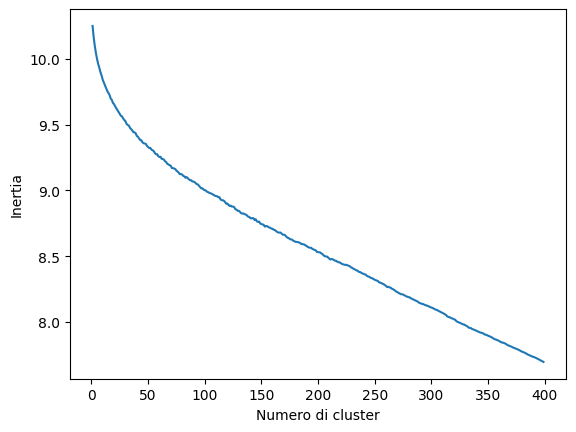

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k_min, k_max, passo = 0, 400, 20

# Determina il numero ottimale di cluster
inertia = []
for k in range(k_min, k_max, passo):
    kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=-1).fit(embedded_labels.iloc[:, :-1]) #-1 perchè nell'ultima riga del dataframe c'è il nome della skill
    inertia.append(kmeans.inertia_)
plt.plot(list(range(k_min, k_max)), inertia)
plt.xlabel('Numero di cluster')
plt.ylabel('Inertia')
plt.show()

In [ ]:
from sklearn.cluster import KMeans

clusters = 600 #Numero di cluster scelto in base al numero di classi e in base al numero di esempi di training

# Definizione del modello di clustering
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(embedded_labels.iloc[:, :-1]) #Passare la matrice delle co-occorrenze al posto di "embedded_labels" per clusterizzare secondo l'altro criterio

# Salvataggio del modello di clustering k-means
joblib.dump(kmeans, percorso_locale+'tensor/kmeans.joblib')

In [ ]:
for cluster in range(0,kmeans.n_clusters):
    print("cluster ",cluster)
    embedded_labels.apply(lambda x:print(f"skill: {x['Skill']}") if x['cluster'] == cluster else None, axis=1)
    print('\n')

In [ ]:
kmeans = joblib.load(percorso_locale+'base/kmeans.joblib')

# Etichette dei cluster
cluster_labels = kmeans.labels_

# Ad ogni skill embeddada viene aggiunto il numero del cluster al quale è stata associata
embedded_labels['cluster'] = cluster_labels

**Definizione delle etichette rappresentative**

In [ ]:
# Centroidi dei cluster per etichette rappresentative
centroids = kmeans.cluster_centers_

# Crea una mappa per sostituire le etichette originali con quelle rappresentative(piu vicine ai centroidi)
cluster_to_label_map = {i: find_representative_skill(i,centroids,embedded_labels) for i in range(kmeans.n_clusters)}

# Stampa le etichette rappresentative dei cluster
print(cluster_to_label_map)

# Crea una mappa tra ogni skill e la sua skill rappresentativa
skill_to_representative_map = embedded_labels.set_index('skill')['cluster'].map(cluster_to_label_map).to_dict()

{0: ' dataflow diagrams (dfds)', 1: ' ability to climb reach bend and lift heavy objects', 2: ' property checklist', 3: ' cutting tools', 4: ' guest complaint and feedback handling', 5: ' activity planning', 6: ' personnel records', 7: ' financial analysis', 8: ' incident documentation', 9: ' psychiatric nursing', 10: ' safety and infection control', 11: ' awards and recognition', 12: ' paid time away for fulltime salaried employees', 13: ' equipment management', 14: ' sanitation and hygiene', 15: 'soccer coaching', 16: ' ongoing training', 17: ' hearing loss not exceeding 25 decibels in either ear in the 500 1000 and 2000 hz ranges', 18: ' interpretation', 19: ' hospital care', 20: ' multitasking skills', 21: ' food handling and storage', 22: ' frequent contact with meat products', 23: ' adherence to policies and practices', 24: ' team leadership and development', 25: ' bilingual spanish speakers (preferred)', 26: ' warehouse supervisor', 27: ' paid vacation holidays and sick leave', 

**Sostituzione delle etichette con l'etichetta rappresentativa del cluster a cui appartengono**

In [ ]:
# Sostituisci le skill nella colonna originale
data['aggregated_skills'] = data['skills'].apply(replace_with_representative_skills)

In [ ]:
# Controllo della composizione dell'insieme delle etichette dopo il clustering
all_skills = [skill for sublist in data['aggregated_skills'] for skill in sublist]
skills_df = pd.DataFrame(all_skills, columns=['aggregated_skills'])
label_counts = skills_df['aggregated_skills'].value_counts()

all_present_labels = label_counts[label_counts == len(data)]
too_common_labels = label_counts[label_counts > 0.95 * len(data)]
too_rare_labels = label_counts[label_counts < 0.01 * len(data)]

print(f"Numero di skills presenti in tutte le descrizioni: {len(list(all_present_labels.index))}")
print(f"Numero di skills troppo comuni (>95%): {len(list(too_common_labels.index))}")
print(f"Numero di skills troppo rare (<1%): {len(list(too_rare_labels.index))}")

# Percentuale di appartenenza alle descrizioni per ogni etichetta
label_percentages = (label_counts / len(data)) * 100
print(f"\nSkill|% di apparizione: \n{label_percentages}")

Numero di skills presenti in tutte le descrizioni: 0
Numero di skills troppo comuni (>95%): 0
Numero di skills troppo rare (<1%): 58

      Skill          |   % di apparizione: 
 property checklist                                                                                                           39.45
 nuclear health and safety hazards                                                                                            38.75
 cherokee federal preemployment qualifications                                                                                32.30
 hospital care                                                                                                                27.20
 communication skills                                                                                                         20.85
 nond.o.t. drug test                                                                                                          19.45
 one year of retail experience

# **Fase 3: Feature Extraction**

**Binarizzazione delle etichette clusterizzate**

In [15]:
# Importazione e inizializzazione del binarizzatore
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Binarizzazione delle etichette aggregate in un dataFrame Pandas
labels = pd.DataFrame(mlb.fit_transform(data['aggregated_skills']), columns=mlb.classes_)

# Salvataggio del binarizzatore
joblib.dump(mlb, percorso_locale+'tensor/mlb.joblib')

labels.head()

,a positive attitude,a1 or d32/d33 qualification,a123 audit,abatement supervisors certification,ability to assess for risk of harm to self or others,ability to assist with unit audits as delegated,ability to conduct regular patient rounds,ability to drive patient outcomes,ability to evaluate clients,ability to follow protocols for the proper fixation and routine staining of samples,...,part number interpretation,power system relay testing,production recruitment,reablement,registered mental nursing certificate (rmn),sped instructional care aid,technology marketing,terminal planning,tools,translating
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Vettorizzazione dei dati di training**

```
# Importazione e inizializzazione del vettorizzatore per TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

# Calcolo dei valori TF-IDF in un DataFrame
# La matrice sparsa viene convertita in un vettore denso prima di creare il dataFrame
tfIdf_array = vectorizer.fit_transform(data['description']).toarray()
tfIdf = pd.DataFrame(tfIdf_array, columns=vectorizer.get_feature_names_out())

# Salvataggio del vettorizzatore
joblib.dump(vectorizer, percorso_locale+'base/vectorizer.joblib')

tfIdf.head()
```

**Embedding delle parole**

In [16]:
import gensim
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(percorso_locale+'w2v_model.bin', binary=True)

['D:/Users/Davide/Documents/Scuola/Uni/Magistrale/Primo Anno/ML/tensor/w2v_desc.joblib']

In [18]:
embedded_desc = pd.DataFrame(data['description'].apply(str).apply(lambda x: get_average_word2vec(x.split(), w2v_model, w2v_model.vector_size)).tolist(), columns=[f'ED{i+1}' for i in range(w2v_model.vector_size)])

embedded_desc.head()

,ED1,ED2,ED3,ED4,ED5,ED6,ED7,ED8,ED9,ED10,...,ED291,ED292,ED293,ED294,ED295,ED296,ED297,ED298,ED299,ED300
0,-0.068401,-0.061983,-0.041027,0.109869,0.118460,0.219022,-0.100165,0.158219,0.030190,0.044720,...,-0.219797,-0.217656,0.196549,-0.128960,-0.115383,0.007789,0.105939,-0.162854,-0.010835,0.070378
1,-0.031642,-0.066775,-0.044533,0.097436,0.074017,0.207502,-0.144740,0.136389,0.012486,0.074077,...,-0.219565,-0.231385,0.210731,-0.176142,-0.112238,-0.028631,0.136838,-0.211605,-0.079869,0.070477
2,-0.071102,-0.029684,-0.047828,0.100263,0.097115,0.225459,-0.139569,0.153536,0.022062,0.037131,...,-0.219047,-0.232772,0.200264,-0.148871,-0.107325,-0.013810,0.113971,-0.179376,-0.092603,0.048393
3,-0.051119,-0.067384,-0.030143,0.127070,0.088654,0.235888,-0.109200,0.138840,0.027137,0.057666,...,-0.210743,-0.233670,0.208664,-0.143151,-0.098940,-0.013658,0.093605,-0.173953,-0.038367,0.030620
4,-0.062273,-0.030511,-0.047339,0.099431,0.082363,0.218341,-0.128407,0.157879,0.016081,0.050349,...,-0.231497,-0.226667,0.185272,-0.138150,-0.108343,0.000077,0.120337,-0.157238,-0.070743,0.067237


In [ ]:
embedded_desc.to_pickle(percorso_locale+'embedded_desc.pkl')

In [ ]:
embedded_desc = pd.read_pickle(percorso_locale+'embedded_desc.pkl')

De-allocazione dei dataframe non più necessari

In [19]:
# De-allocazione del dataFrame data in quanto non più necessario
import gc
del data
del embedded_labels
gc.collect()

21

# **Step 4: Riduzione di dimensionalità**

**Individuazione del numero ottimale di componenti principali**

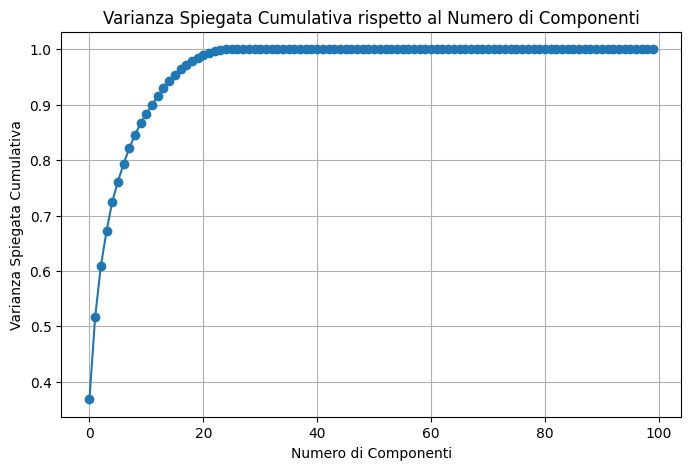

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Inizializzare e fit di PCA senza specificare il numero di componenti
pca = PCA()
pca.fit(embedded_desc)

# Calcolare la varianza spiegata cumulativa
explained_variance = pca.explained_variance_ratio_.cumsum() #.to_array()

# Plot della varianza spiegata cumulativa
plt.figure(figsize=(8, 5))
plt.plot(explained_variance, marker='o')
plt.xlabel('Numero di Componenti')
plt.ylabel('Varianza Spiegata Cumulativa')
plt.title('Varianza Spiegata Cumulativa rispetto al Numero di Componenti')
plt.grid(True)
plt.show()

**Calcolo delle componenti principali**

In [31]:
# Definizione del numero ottimale di componenti dello spazio di destinazione
pc = np.where(explained_variance >= 0.9)[0][0] + 1 # Preleviamo il numero minimo di componenti per spiegare il 90% della varianza

# Inizializzazione e fit del riduttore di dimensionalità
pca = PCA(n_components=pc)
embedded_desc_reduced = pd.DataFrame(pca.fit_transform(embedded_desc), columns=[f'PC{i+1}' for i in range(pc)])

# Salvataggio del riduttore
joblib.dump(pca, percorso_locale+'tensor/pca.joblib')

embedded_desc_reduced.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,0.029844,-0.052391,-0.018265,0.004834,-0.055406,-0.011055,0.005920,-0.004583,-0.022007,0.012888,0.010242,-0.029193,0.013906,-0.038804,-0.008338,-0.008151,0.007714,0.026606,0.008935,0.004529
1,-0.070587,0.041425,0.000207,0.034244,-0.033959,0.001277,0.000778,0.007823,0.015470,0.003646,0.014739,0.011905,-0.005015,0.016155,-0.005216,0.007882,-0.001415,-0.001117,-0.007761,-0.002381
2,-0.014109,0.036196,0.009136,-0.030227,0.020885,-0.015575,0.002725,-0.011638,0.012998,-0.013867,-0.002204,-0.001102,-0.006740,0.003591,-0.002954,-0.002993,0.004248,0.005551,0.002732,-0.003140
3,0.010459,-0.028233,-0.021223,-0.019305,-0.011407,0.022316,-0.006721,-0.001782,-0.014178,-0.016058,0.014422,-0.008138,0.019983,-0.006963,-0.005953,0.009763,-0.004080,-0.001118,-0.002106,-0.001325
4,0.011694,0.038893,0.027250,-0.004187,0.005890,0.001364,-0.017051,0.008170,-0.001589,-0.005949,-0.005651,-0.003219,-0.012657,-0.018067,0.004952,0.002498,-0.007822,-0.002112,0.008739,0.002727


# **Step 5: Creazione del Modello**

**Split del dataset**

In [20]:
from sklearn.model_selection import train_test_split as train_test_split

# Dividere in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(embedded_desc, labels, test_size=0.2, random_state=42)

Il primo argomento di 'train_test_split' è il set di dati (descrizioni), il secondo argomento è il set di etichette ad essi associate (skills).

Si tiene traccia delle corrispondenze tra dati ed etichette tramite gli indici dei dataFrame, che devono coincidere.

In [21]:
# Salva i dati
joblib.dump((X_train, X_test, y_train, y_test), percorso_locale + 'tensor/train_test_split.joblib')

['D:/Users/Davide/Documents/Scuola/Uni/Magistrale/Primo Anno/ML/tensor/train_test_split.joblib']

In [5]:
# Carica i dati
X_train, X_test, y_train, y_test = joblib.load(percorso_locale + 'tensor/train_test_split.joblib')

In [3]:
# Carica i dati
X_train, X_test, y_train, y_test = joblib.load(percorso_locale + 'base/train_test_split.joblib')

**K-fold Cross Validation**

In [ ]:
# Definizione della cross-validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Utilizzo K-fold
for train_index, test_index in kf.split(embedded_desc):
    X_train, X_test = embedded_desc.iloc[train_index], embedded_desc.iloc[test_index]
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]

**Definizione del modello**

La rete neurale dovrà approssimare un classificatore multi-etichetta binario, che ritornerà 1 se l'input appartiene ad una classe e 0 altrimenti.

Processo da seguire per migliorare le prestazioni del modello:

1. **Verifica del Numero di Epoche**: Verificare che il modello abbia avuto abbastanza tempo per addestrarsi. Controllare le curve di apprendimento e se non hanno ancora raggiunto un plateau, provare ad aumentare il numero di epoche.

2. **Aumento del Numero di Nodi**: Se il modello sembra riscontrare underfitting (ad esempio, bassa accuratezza sia su training che su validation), provare ad incrementare il numero di nodi nei layer esistenti. Iniziare con piccoli incrementi e valutare se le prestazioni migliorano.

3. **Aggiunta di altri Strati Nascosti**: Se il problema è molto complesso e il modello con più nodi per layer non è ancora sufficiente, valutare l’aggiunta di un altro strato nascosto. Ricordando però che ogni strato aggiuntivo aumenta la complessità e il rischio di overfitting.

4. **Regolarizzazione e Dropout**: Se si inizia a vedere segni di overfitting con più nodi o strati, considerare tecniche di regolarizzazione come il dropout o la regolarizzazione L2.

In [4]:
# Definizione del modello usando TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer,Dense, Dropout, BatchNormalization

input_dim = X_train.shape[1] # Dovrebbe corrispondere al numero di valori del vettore di embedding (100)
output_dim = y_train.shape[1] # Dovrebbe corrispondere al numero di cluster (500)

# Creazione del modello TensorFlow
model = Sequential([
    InputLayer(input_shape=(input_dim,)), # Dimensione di input pari al numero di valori del vettore di embedding
    Dense(8192, activation='relu'),
    BatchNormalization(),
    Dense(4096, activation='relu'),
    BatchNormalization(),
    Dense(2048, activation='relu'),
    BatchNormalization(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dense(output_dim, activation='sigmoid') # Dimensione di output pari al numero di classi e funzione di attivazione a sigmoide per output binario
])

# Compila il modello
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # La funzione di loss è la binary crossentropy poichè la classificazione è binaria su 500 classi

# Stampa il sommario del modello
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              819200    
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 4096)              33558528  
                                                                 
 batch_normalization_1 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 2048)              8390656   
                                                                 
 batch_normalization_2 (Batc  (None, 2048)             8

# **Step 6: Addestramento del modello**

In [5]:
# Aggiungi EarlyStopping per evitare l'overfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss', # Si monitora la perdita sul set di validazione
    patience=5, # Numero di epoche da attendere prima di fermarsi dopo un miglioramento
    restore_best_weights=True # Ripristina i pesi del modello con le migliori prestazioni
)

# Addestramento
history = model.fit(
    X_train, y_train, # Dati di addestramento
    epochs=100, # Numero massimo di epoche
    batch_size=64, # Dimensione del batch di addestramento
    validation_data=(X_test, y_test), # Dati di validazione
    callbacks=[early_stopping] # Applica l'early stopping
)

# Salvataggio del modello
model.save(percorso_locale+'tensor/model/')

Epoch 1/100
14723/14723 [==============================] - 376s 24ms/step - loss: 0.0841 - accuracy: 0.0302 - val_loss: 0.0794 - val_accuracy: 0.0374
Epoch 2/100
14723/14723 [==============================] - 357s 24ms/step - loss: 0.0788 - accuracy: 0.0340 - val_loss: 0.0773 - val_accuracy: 0.0362
Epoch 3/100
14723/14723 [==============================] - 355s 24ms/step - loss: 0.0771 - accuracy: 0.0357 - val_loss: 0.0761 - val_accuracy: 0.0345
Epoch 4/100
14723/14723 [==============================] - 351s 24ms/step - loss: 0.0758 - accuracy: 0.0367 - val_loss: 0.0752 - val_accuracy: 0.0377
Epoch 5/100
14723/14723 [==============================] - 356s 24ms/step - loss: 0.0747 - accuracy: 0.0381 - val_loss: 0.0746 - val_accuracy: 0.0391
Epoch 6/100
14723/14723 [==============================] - 359s 24ms/step - loss: 0.0737 - accuracy: 0.0392 - val_loss: 0.0741 - val_accuracy: 0.0412
Epoch 7/100
14723/14723 [==============================] - 363s 25ms/step - loss: 0.0728 - accuracy:

Curve di apprendimento

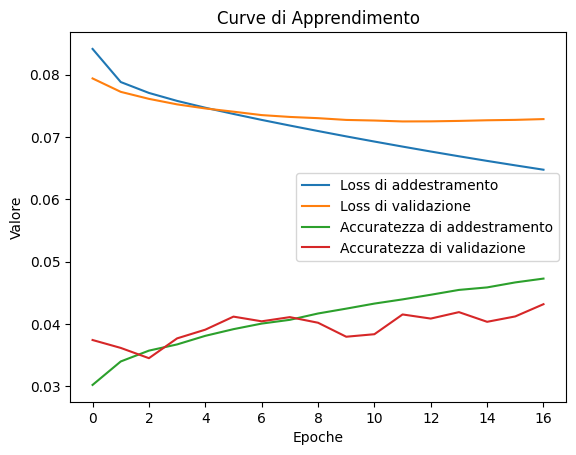

In [6]:
import matplotlib.pyplot as plt

# Stampa le curve di apprendimento
plt.plot(history.history['loss'], label='Loss di addestramento')
plt.plot(history.history['val_loss'], label='Loss di validazione')
plt.plot(history.history['accuracy'], label='Accuratezza di addestramento')
plt.plot(history.history['val_accuracy'], label='Accuratezza di validazione')
plt.title('Curve di Apprendimento')
plt.xlabel('Epoche')
plt.ylabel('Valore')
plt.legend(loc='best')
plt.show()

# **Step 7: Valutazione del modello**

In [12]:
mlb = joblib.load(percorso_locale+'base/mlb.joblib')

In [13]:
from sklearn.metrics import accuracy_score, classification_report

# Predizione
y_pred = model.predict(X_test)

# Converti le predizioni in valori binari
y_pred_binary = (y_pred > 0.5).astype(int)

# Valutazione dell'accuratezza
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy}')

# Report di classificazione
print(classification_report(y_test, y_pred_binary, target_names=mlb.classes_))

7362/7362 [==============================] - 24s 3ms/step
Accuracy: 0.002275448084972703


d:\Anaconda\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


d:\Anaconda\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Esempio di utilizzo**

In [9]:
# Caricare i modelli salvati
#vectorizer = joblib.load(percorso_locale + 'tensor/vectorizer.joblib')
w2v = joblib.load(percorso_locale+'tensor/w2v_desc.joblib')
#pca = joblib.load(percorso_locale+'tensor/pca.joblib')
model = tf.keras.models.load_model(percorso_locale+'tensor/model/')
mlb = joblib.load(percorso_locale+'tensor/mlb.joblib')
vector_size = 100

# Input testo
stringa = "web developer"

# Pulizia testo
stringa_clean = preprocess(stringa)

# Vettorizzazione testo
#stringa_tfIdf = vectorizer.transform([stringa_clean])

# Embedding dell'input
stringa_embedded = get_average_word2vec(stringa_clean, w2v, vector_size)
stringa_embedded = stringa_embedded.reshape(1, -1)  # Aggiungi una dimensione per batch

# Estrazione componenti principali testo (PCA)
#stringa_PCs = pca.transform(stringa_tfIdf.toarray())

# Predizione
prediction= model.predict(stringa_embedded)
pred_binary = (prediction > 0.5).astype(int)

# Stampa
print('List of required skills: ' + str(mlb.inverse_transform(pred_binary)))

1/1 [==============================] - 0s 443ms/step
List of required skills: [(' anesthesia techs',)]
